In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lectura de datos

In [2]:
pd.options.plotting.backend = 'plotly' 

In [13]:
dataset = pd.read_csv('app.csv', sep = ';')
dataset['time'] = pd.to_datetime(dataset['time'])
dataset = dataset.set_index('time')
dataset.head().style

/tmp/ipykernel_3287/4156154006.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['time'] = pd.to_datetime(dataset['time'])


,users,sessions,newusers,crashes
time,,,,
2018-12-22 09:00:00,64,60,5,0
2018-12-22 10:00:00,79,84,8,0
2018-12-22 11:00:00,97,102,22,0
2018-12-22 12:00:00,107,102,13,0
2018-12-22 13:00:00,105,117,10,2


In [20]:
dataset.users.plot()

Al realizar un análisis visual de los datos, podemos observar que el periodo de usos de la aplicación tiene patrones que se repiten diariamente, alcanzando picos de inicios de sesión en horarios nocturnos. Ahora vamos a generar un correlograma para esa serie de tiempo, en el que analizaremos la correlación parcial a lo largo del tiempo.  
Al generar la gráfica podemos ver que de cierta manera hay un mapeo entre los picos de uso de la aplicación, contra los picos y caídas en la gráfica de autocorrelación. 

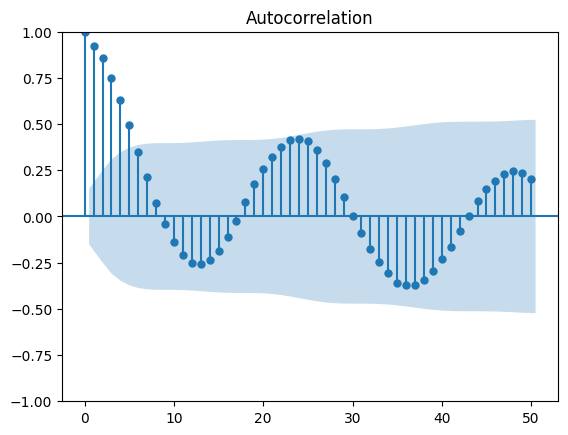

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dataset.users, lags=50)
plt.show()

## Descomposición con modelos aditivos

Para analizar con mayor nivel de detalle la serie de tiempo, vamos a descomponerla.  
La serie de tiempo está compuesta por estacionalidad (patrones cíclicos en el tiempo), tendencia (aumentan o decrecen sus valores) y ruido (aleatoriedad en los datos).  
Vamos a utilizar un modelo clásico para descomponer la serie:  
* S(t): estacionalidad
* T(t): tendencia
* R(t): residualidad  
  
Pasos:
1. Media móvil para estimar T(t)  - Calcula el promedio por ventanas
2. Media móvil o suavizado exponencial para estimar S(t)  
3. R(t) se calcula a partir de la serie original y(t) y de los componentes T(t) y S(t) en el tiempo t.  
  


Hay varias formas de expresar la descomposición sobre la serie:  
* Componentes aditivos: y(t) = T(t) + S(t) + R(t)  
* Componentes multiplicativos: .y() = T(t) * S(t) * R(t)




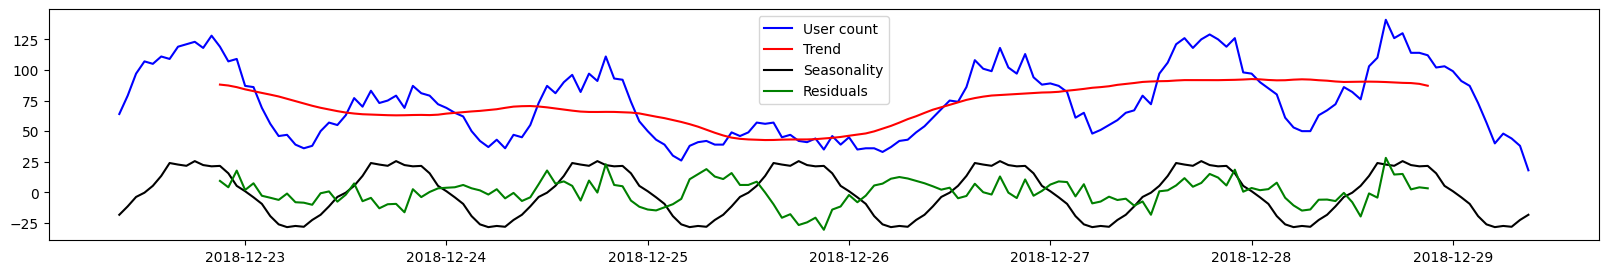

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset['users'], model = 'aditive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 3))
plt.plot(dataset['users'], color='blue',label='User count')
plt.plot(trend, color='red', label='Trend')
plt.plot(seasonal, color='black', label='Seasonality')
plt.plot(residual, color='green', label='Residuals')
plt.legend(loc='best')


## Descomposición con modelos STL

Estos modelos son más robustos en comparación con los modelos anteriores, se siguen los siguientes pasos:  
1. Se estima la estacionalidad de la serie usando regresión local con N vecinos (N depende de la periodicidad)  
2. Con la estacionalidad estimada, se elimina de la serie original:  (*Serie resultante = serie original - estacionalidad*)  
3. Con la serie resultante se usa regresión local para determinar variaciones a largo plazo (Tendencia)  
4. Se calcula el residual con los valores restantes.  
Este método es más robusto en comparación con el anterior, porque no supone linealidad o tendencia en los datos, sino que se ajusta a los patrones que presentan.

<Figure size 2000x300 with 0 Axes>

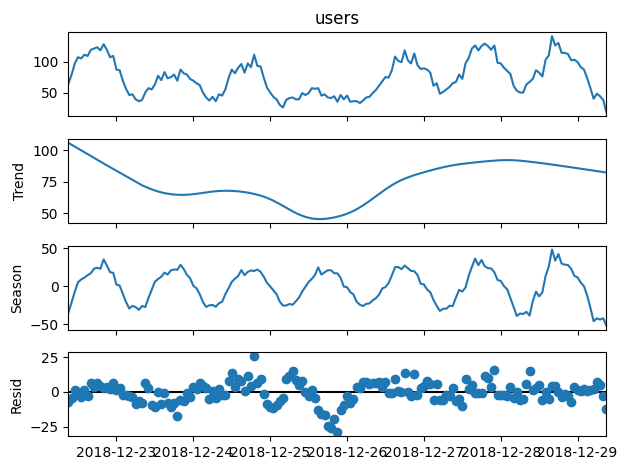

In [35]:
from statsmodels.tsa.seasonal import STL
decomposition = STL(dataset['users']).fit()

plt.figure(figsize=(20, 3))
decomposition.plot()
plt.show()

In [36]:
from statsmodels.tsa.stattools import adfuller
adfuller(dataset['users'])


(np.float64(-4.423338352702992),
 np.float64(0.00026984009571639014),
 5,
 163,
 {'1%': np.float64(-3.471118535474365),
  '5%': np.float64(-2.8794405060097024),
  '10%': np.float64(-2.576313761526591)},
 np.float64(1129.0934985237159))

## Cual modelo podemos utilizar para analizar series con estacionalidad?

El modelo de SARIMA es ideal para realizar análisis en series de tiempo que presentan componentes estacionales. Modelos clásicos como ARIMA no son muy precisos cuando las series de tiempo presentan periodos de estacionalidad. En este punto el modelo ***Seasonal Autorregressive Integrated Moving Average**.  
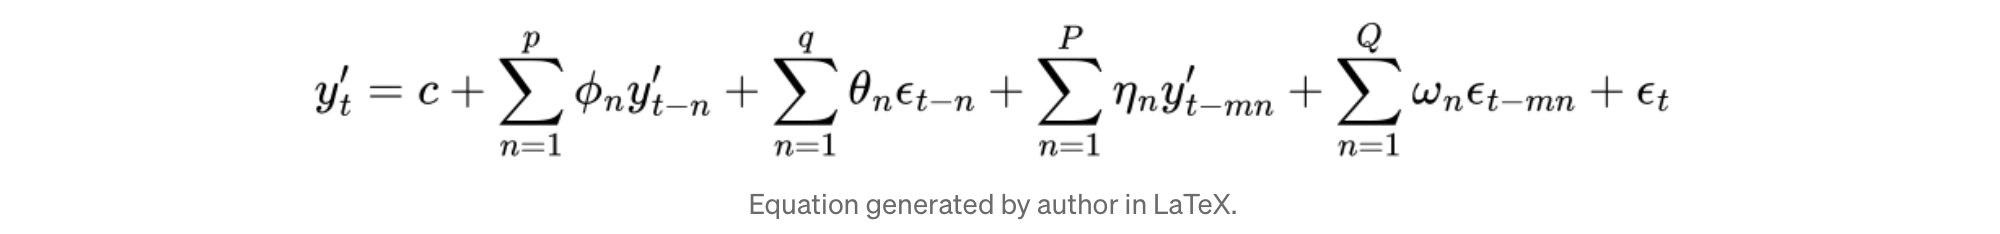  

En donde:
y’: Es la serie de tiempo diferenciada en el componente regular d, y estacionalidad D  

P: Número de autorregresores en temporalidad  

ω: Coeficientes de los componentes autorregresivos asociados a la estacionalidad  

Q: Número de componentes de la media móvil  

η: Coeficientes de los errores estacionales  

m: longitud de la estacionalidad


### Requerimientos para aplicar SARIMA

Estos modelos al igual que los ARIMA necesitan que la serie de tiempo sea estacionaria, de tal manera que a largo plazo, sus propiedades estadísticas como promedio y varianza se mantengan constantes.  
Para volver estacionarios los datos, es necesario estabilizar el promedio y la varianza. El promedio puede ser estabilizado al diferenciar el componente de estacionalidad *D*, y diferencial *d*.  
La selección de los órdenes se hace de la siguiente manera:  
* Componente estacional D,  y diferencial: Se calcula al hallar la autocorrelación parcial PACF y autocorrelación ACF.  Esto también se puede deducir con el test de Dickey-Fuller para determinar si la serie es estacional.  
* Lo órdenes de las medias móviles autorregresivas (p, q , P, Q): Se pueden calcular con ACF y PACF de los autorregresores y la media movil, para deducir las valores que son estadísticamente significantes.  


Estimation
The final step is to compute the corresponding coefficients for these orders. The most common method is to use Maximum Likelihood Estimation (MLE) which estimates the coefficients against some assumed probability distribution, typically normal, to calculate which coefficient is the most likely to generate that data. As the time series is stationary and has constant statistical properties, we can say that it belongs to some probability distribution allowing us to use MLE. This is why stationarity is the key requirement for SARIMA.